<a href="https://colab.research.google.com/github/MahdiBouzaher/Facial_emotion_recognition_with_ML/blob/main/facial_emotion_recognition_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow_datasets as tfds

# **Loading JAFFE Dataset**

In [99]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)

        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code == "DI":
            continue
        if img is not None:
            images.append(img)
    return images

# Loading The images
JAFFE_PATH = "/content/drive/MyDrive/AI_assignement_1/JAFFE_DS"
jaffe_images= load_images_from_folder(JAFFE_PATH)
jaffe_images = np.array(jaffe_images)

In [100]:
# Function to create y_ndarray using from the file name
def get_y_from_filenames(folder):
    emotions = {'AN':0, 'FE':1, 'HA':2, 'SA':3, 'SU':4, 'NE':5}
    y = []
    for filename in os.listdir(folder):
        parts = filename.split('.')
        if len(parts) < 2:
            continue
        code = parts[1][:2]
        if code in emotions:
            y.append(emotions[code])
    return np.array(y)

# Passing the path of the folder to the function to get y ndarray
y_jaffe = get_y_from_filenames(JAFFE_PATH)

print(f"CK images shape: {jaffe_images.shape}")
print(f"JAFFE labels: {np.unique(y_jaffe)}")
print(f"CK label counts: {np.bincount(y_jaffe)}")
emotions_labels=['ANGER', 'FEAR', 'HAPPINESS', 'SADNESS', 'SURPRISE', 'NEUTRAL']

CK images shape: (184, 256, 256)
JAFFE labels: [0 1 2 3 4 5]
CK label counts: [30 32 31 31 30 30]


# **Loading CK+ Dataset**

In [101]:
# Loading CK+ dataset
CK_PATH = "/content/drive/MyDrive/AI_assignement_1/Cohn-Kanade.csv"
df = pd.read_csv(CK_PATH)
df = df.drop(columns=['Usage'])

# Remove disgust (1) and contempt (7)
df = df[df['emotion'] != '1']
df = df[df['emotion'] != '7']

# Map emotions to 0-5 range
emotion_mapping = {0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
df['emotion_mapped'] = df['emotion'].astype(int).map(emotion_mapping)

# Remove any NaN values from mapping
df = df.dropna(subset=['emotion_mapped'])

# Extract images
ck_images = np.array([np.fromstring(str(x), sep=' ') for x in df['pixels']])
ck_images = ck_images.reshape(-1, 48, 48)

# Use MAPPED labels
y_ck = df['emotion_mapped'].values.astype(int)

print(f"CK images shape: {ck_images.shape}")
print(f"CK labels: {np.unique(y_ck)}")
print(f"CK label counts: {np.bincount(y_ck)}")

CK images shape: (843, 48, 48)
CK labels: [0 1 2 3 4 5]
CK label counts: [ 45  25  69  28  83 593]


# **Function to reshape all images from both datasets to 64x64**
JAFFE   256 X 256 => 64 X 64

CK+     48 X 48 => 64 X 64

In [102]:
# Function to resize all images to 64x64
def resize_images(images):
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized_image)
    return np.array(resized_images)

# Call the function to resize the images
ck_images = resize_images(ck_images)
jaffe_images = resize_images(jaffe_images)

print(ck_images.shape)
print(jaffe_images.shape)

(843, 64, 64)
(184, 64, 64)


# **Face Detection**

In [103]:
# Raw GitHub URL for the face cascade
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/refs/heads/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Name for the local file
HAAR_CASCADE_FILE = 'haarcascade_frontalface_default.xml'

# Download the cascade file
import urllib.request
urllib.request.urlretrieve(HAAR_CASCADE_URL, HAAR_CASCADE_FILE)

# Loading the Cascade
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILE)

# function to detect faces
def detect_face(images):
    # In your detect_face function
    face_images = []
    for image in images:
        gray = image.copy().astype(np.uint8)
        face_rect = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5)

        if len(face_rect) > 0:
            # Assume only one face, take the first one
            (x, y, w, h) = face_rect[0]
            # CROP the image to the face
            face_cropped = gray[y:y+h, x:x+w]
            # Resize the cropped face to a standard size so HOG works consistently
            face_resized = cv2.resize(face_cropped, (64, 64), interpolation=cv2.INTER_AREA)
            face_images.append(face_resized)
        else:
            # If no face is detected append the original resized image
            face_images.append(gray)

    return np.array(face_images)

# Detecting face on jaffe dataset
jaffe_X = detect_face(jaffe_images)
jaffe_X = np.array(jaffe_X)

# Detecting face on ck dataset
X_ck = detect_face(ck_images)
X_ck = np.array(X_ck)

# **HOC  + PCA + SCALING Functions**

In [104]:
def get_hog_features(images):
    hog_X = []
    for image in images:
       hog_X_features, hog_image = hog(image, orientations=9,
                                          pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2),
                                          visualize=True)
       hog_X.append(hog_X_features)
    return hog_X

In [105]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


In [106]:
def pca(X_train, X_test):
    pca = PCA(n_components=60, whiten=True, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

    return X_train_pca, X_test_pca

# **Data Augmentation**

In [145]:
def augment_data(images, labels):
  X_augmented_data = []
  y_augmented_data = []
  for i in range(len(images)):
    image = images[i]
    label = labels[i]
    # Add channel dimension
    image_with_channel = tf.expand_dims(image, axis=-1)

    # Check the label at the current index
    if label != 5:
      # Horizontal Flip
      X_augmented_data.append(tf.image.flip_left_right(image_with_channel).numpy())
      y_augmented_data.append(label)

      # Contrast Variation
      X_augmented_data.append(tf.image.random_contrast(image_with_channel, lower=0.8, upper=1.2))
      y_augmented_data.append(label)


      # Adjust Brightness
      X_augmented_data.append(tf.image.adjust_brightness(image_with_channel, delta= 0.1).numpy())
      y_augmented_data.append(label)

      # Rotate by 5 degrees
      # Convert to float32 for rotation and add batch dimension
      image_float_batch = tf.expand_dims(tf.image.convert_image_dtype(image_with_channel, dtype=tf.float32), axis=0)
      rotated_image = tf.keras.layers.RandomRotation(factor=0.05, seed=42)(image_float_batch)
      # Ensure rotated image is 64x64 and remove batch and channel dimensions
      rotated_image_processed = tf.image.resize(tf.squeeze(rotated_image, axis=0), (64, 64)).numpy()
      X_augmented_data.append(rotated_image_processed)
      y_augmented_data.append(label)

    if label == 0 or label == 1 or label == 3:

      # Rotate by 5 degrees
      # Convert to float32 for rotation and add batch dimension
      image_float_batch = tf.expand_dims(tf.image.convert_image_dtype(image_with_channel, dtype=tf.float32), axis=0)
      rotated_image = tf.keras.layers.RandomRotation(factor=0.05, seed=42)(image_float_batch)
      # Ensure rotated image is 64x64 and remove batch and channel dimensions
      rotated_image_processed = tf.image.resize(tf.squeeze(rotated_image, axis=0), (64, 64)).numpy()
      X_augmented_data.append(rotated_image_processed)
      y_augmented_data.append(label)

      # Adjust Brightness
      X_augmented_data.append(tf.image.adjust_brightness(image_with_channel, delta= 0.1).numpy())
      y_augmented_data.append(label)

      # Contrast Variation
      X_augmented_data.append(tf.image.random_contrast(image_with_channel, lower=0.8, upper=1.2))
      y_augmented_data.append(label)

  X_augmented_data = np.array(X_augmented_data)
  y_augmented_data = np.array(y_augmented_data)
  # Reshape images
  X_augmented_data = X_augmented_data.reshape(-1, 64, 64)
  return X_augmented_data, y_augmented_data

# **Combine Original and Augmented Data**

In [146]:
X_augmented_data_jaffe, y_augmented_data_jaffe = augment_data(jaffe_images, y_jaffe)
X_augmented_data_ck, y_augmented_data_ck = augment_data(X_ck, y_ck)

# Combine original and augmented data for JAFFE
X_jaffe_combined_aug = np.vstack([jaffe_images, X_augmented_data_jaffe])
y_jaffe_combined_aug = np.concatenate([y_jaffe, y_augmented_data_jaffe])

# Combine original and augmented data for CK+
X_ck_combined_aug = np.vstack([X_ck, X_augmented_data_ck])
y_ck_combined_aug = np.concatenate([y_ck, y_augmented_data_ck])

# Combine both datasets (original + augmented)
X_combined_final = np.vstack([X_jaffe_combined_aug, X_ck_combined_aug])
y_combined_final = np.concatenate([y_jaffe_combined_aug, y_ck_combined_aug])

print(f"Final combined dataset shape: {X_combined_final.shape}")
print(f"Final combined labels shape: {y_combined_final.shape}")
print(f"Final label distribution: {np.bincount(y_combined_final.astype(int))}")

Final combined dataset shape: (3216, 64, 64)
Final combined labels shape: (3216,)
Final label distribution: [600 456 500 472 565 623]


# **Random Forest Model**

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    random_state=42
)

# **Training and testing**

In [133]:
print("\nTesting on JAFFE Dataset")

# Extract HOG features
hog_X_jaffe = get_hog_features(jaffe_X)
hog_X_jaffe = np.array(hog_X_jaffe)

# Flatten HOG features
hog_X_jaffe = hog_X_jaffe.reshape(hog_X_jaffe.shape[0], -1)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(hog_X_jaffe,
                                                    y_jaffe, test_size=0.3,
                                                    random_state=42)

# Scale (fit on train, transform both)
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

print("\nWITHOUT PCA")
# Train WITHOUT PCA
rf_model.fit(X_train_scaled, y_train)
score_no_pca = rf_model.score(X_test_scaled, y_test)
print(f"Accuracy WITHOUT PCA: {score_no_pca:.2%}")

print("\nWITH PCA")
# Step 5: Add PCA
X_train_pca, X_test_pca = pca(X_train_scaled, X_test_scaled)

# Train WITH PCA
rf_model.fit(X_train_pca, y_train)
score_with_pca = rf_model.score(X_test_pca, y_test)
print(f"Accuracy WITH PCA: {score_with_pca:.2%}")


Testing on JAFFE Dataset

WITHOUT PCA
Accuracy WITHOUT PCA: 60.71%

WITH PCA
Explained variance: 81.87%
Accuracy WITH PCA: 62.50%


In [134]:
print("\nTesting on CK+ Dataset")

# Extract HOG features
hog_X_ck = np.array(get_hog_features(X_ck))
print(f"CK+ HOG shape: {hog_X_ck.shape}")

# Split dataset
X_train_ck, X_test_ck, y_train_ck, y_test_ck = train_test_split(hog_X_ck,
                                                                y_ck,
                                                                test_size=0.3,
                                                                random_state=42)

# Scale data
X_train_ck_scaled, X_test_ck_scaled = scale_data(X_train_ck, X_test_ck)

# Train WITHOUT PCA
print("\nWITHOUT PCA")
rf_model.fit(X_train_ck_scaled, y_train_ck)
score_no_pca = rf_model.score(X_test_ck_scaled, y_test_ck)
print(f"Accuracy WITHOUT PCA: {score_no_pca:.2%}")

# Train WITH PCA
print("\nWITH PCA")
X_train_ck_pca, X_test_ck_pca = pca(X_train_ck_scaled, X_test_ck_scaled)
rf_model.fit(X_train_ck_pca, y_train_ck)
score_with_pca = rf_model.score(X_test_ck_pca, y_test_ck)
print(f"Accuracy WITH PCA: {score_with_pca:.2%}")


Testing on CK+ Dataset
CK+ HOG shape: (843, 1764)

WITHOUT PCA
Accuracy WITHOUT PCA: 83.79%

WITH PCA
Explained variance: 57.53%
Accuracy WITH PCA: 78.66%


In [135]:
print("COMBINING BOTH DATASETS")

# Extract HOG features from both
hog_X_jaffe = get_hog_features(jaffe_X)
hog_X_jaffe = np.array(hog_X_jaffe)

hog_X_ck = get_hog_features(X_ck)
hog_X_ck = np.array(hog_X_ck)

# Combine datasets
X_combined = np.vstack([hog_X_jaffe, hog_X_ck])
y_combined = np.concatenate([y_jaffe, y_ck])

print(f"Combined dataset shape: {X_combined.shape}")
print(f"Combined labels shape: {y_combined.shape}")
print(f"Label distribution: {np.bincount(y_combined.astype(int))}")

# Split combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined,
                                                                                        y_combined,
                                                                                        test_size=0.3,
                                                                                        random_state=42,
                                                                                        stratify=y_combined)

# Scale
X_train_combined_scaled, X_test_combined_scaled = scale_data(X_train_combined, X_test_combined)

# Train Without PCA
print("\nWITHOUT PCA")
rf_model.fit(X_train_combined_scaled, y_train_combined)
score_combined_no_pca = rf_model.score(X_test_combined_scaled, y_test_combined)
print(f"Accuracy WITHOUT PCA: {score_combined_no_pca:.2%}")

# Train With PCA
print("\nWITH PCA")
X_train_combined_pca, X_test_combined_pca = pca(X_train_combined_scaled, X_test_combined_scaled)
rf_model.fit(X_train_combined_pca, y_train_combined)
score_combined_with_pca = rf_model.score(X_test_combined_pca, y_test_combined)
print(f"Accuracy WITH PCA: {score_combined_with_pca:.2%}")



COMBINING BOTH DATASETS
Combined dataset shape: (1027, 1764)
Combined labels shape: (1027,)
Label distribution: [ 75  57 100  59 113 623]

WITHOUT PCA
Accuracy WITHOUT PCA: 79.94%

WITH PCA
Explained variance: 58.41%
Accuracy WITH PCA: 74.76%


# **Train and Evaluate on Combined (Original + Augmented) Data**


Testing on COMBINED (Original + Augmented) Dataset

WITHOUT PCA
Accuracy WITHOUT PCA: 93.06%

WITH PCA
Explained variance: 61.55%
Accuracy WITH PCA: 93.06%

Classification Report for COMBINED (Original + Augmented) Dataset (WITH PCA)
              precision    recall  f1-score   support

       ANGER       0.97      0.97      0.97       180
        FEAR       0.95      0.89      0.92       137
   HAPPINESS       0.92      0.95      0.93       150
     SADNESS       0.92      0.87      0.89       142
    SURPRISE       0.89      0.95      0.92       169
     NEUTRAL       0.93      0.95      0.94       187

    accuracy                           0.93       965
   macro avg       0.93      0.93      0.93       965
weighted avg       0.93      0.93      0.93       965

Confusion Matrix for COMBINED (Original + Augmented) Dataset (WITH PCA)


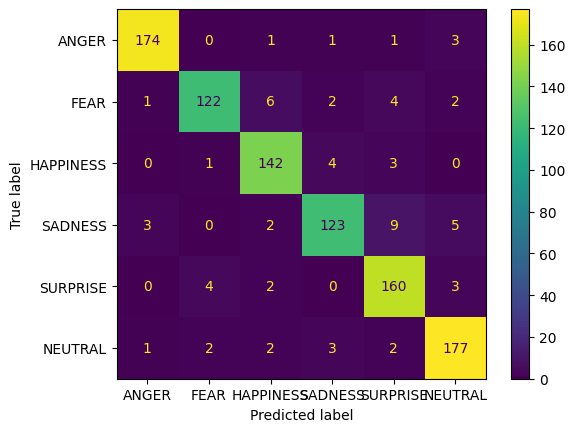

In [149]:
print("\nTesting on COMBINED (Original + Augmented) Dataset")

# Extract HOG features from combined data
hog_X_combined_final = get_hog_features(X_combined_final)
hog_X_combined_final = np.array(hog_X_combined_final)

# Split combined data
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(hog_X_combined_final,
                                                                            y_combined_final,
                                                                            test_size=0.3,
                                                                            random_state=42,
                                                                            stratify=y_combined_final)

# Scale
X_train_final_scaled, X_test_final_scaled = scale_data(X_train_final, X_test_final)

# Train Without PCA
print("\nWITHOUT PCA")
rf_model.fit(X_train_final_scaled, y_train_final)
score_combined_no_pca = rf_model.score(X_test_final_scaled, y_test_final)
print(f"Accuracy WITHOUT PCA: {score_combined_no_pca:.2%}")

# Train With PCA
print("\nWITH PCA")
X_train_final_pca, X_test_final_pca = pca(X_train_final_scaled, X_test_final_scaled)
rf_model.fit(X_train_final_pca, y_train_final)
score_combined_with_pca = rf_model.score(X_test_final_pca, y_test_final)
print(f"Accuracy WITH PCA: {score_combined_with_pca:.2%}")

# Classification Report and Confusion Matrix WITH PCA
y_pred_combined_with_pca = rf_model.predict(X_test_final_pca)
print("\nClassification Report for COMBINED (Original + Augmented) Dataset (WITH PCA)")
print(classification_report(y_test_final, y_pred_combined_with_pca, target_names=emotions_labels))
print("Confusion Matrix for COMBINED (Original + Augmented) Dataset (WITH PCA)")
ConfusionMatrixDisplay.from_predictions(y_test_final, y_pred_combined_with_pca, display_labels=emotions_labels)
plt.show()